# TR-RB simulation

Luca Mechelli, Tim Keil

# Preparations

## details

In [1]:
import numpy as np

from matplotlib import pyplot as plt

from pymor.basic import *
set_log_levels({'pymor': 'WARN'})

In [2]:
from pymor.core.logger import set_log_levels, getLogger
set_log_levels({'pymor': 'ERROR',
                'distributed_adaptive_discretizations': 'DEBUG',
                'notebook': 'INFO'})
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12.0, 8.0)
mpl.rcParams['font.size'] = 12
mpl.rcParams['savefig.dpi'] = 300

## problem definition

In [3]:
from pymor.discretizers.builtin.cg import InterpolationOperator

grid, bi = load_gmsh('../../../fin_data/fin_mesh.msh')

from pdeopt.problems import Fin_problem

problem = Fin_problem(6)
mu_d = problem.parameter_space.sample_randomly(1, seed=222)[0] # 222
mu_d['biot'] = np.array(0.01)
# mu_for_u_d['k2'] = np.array(10)
mu_d['k0'] = np.array(0.1)
#mu_d['k3'] = np.array(0.1)
#mu_for_u_d['k4'] = np.array(0.1)
print('mu desired:', mu_d)

from pdeopt.discretizer import discretize_fin_pdeopt_stationary_cg

opt_fom, data, mu_bar = discretize_fin_pdeopt_stationary_cg(problem, grid, bi, mu_d, 
                                                            product='fixed_energy',
                                                            add_constant_term=True)

mu desired: {biot: 0.01, k0: 0.1, k1: 8.37317446377103, k2: 6.572276066240383, k3: 0.46651735398635275, k4: 1.8835410659596712}
I am using the corrected functional!!
I am using the OLD gradient!!
{biot: 0.1, k0: 1.0, k1: 1.0, k2: 1.0, k3: 1.0, k4: 1.0}
my product is fixed_energy


In [4]:
print('information on the grid:')
print(data['grid'])

radius = 0.1               # TR radius 
FOC_tolerance = 5e-4       # tau_FOC
sub_tolerance = 1e-8       # tau_sub
safety_tol = 1e-16         # Safeguard, to avoid running the optimizer for really small difference in digits
max_it = 40                # Maximum number of iteration for the TR algorithm
max_it_sub = 400           # Maximum number of iteration for the TR optimization subproblem
max_it_arm = 50            # Maximum number of iteration for the Armijo rule
init_step_armijo = 0.5     # Initial step for the Armijo rule
armijo_alpha = 1e-4        # kappa_arm
beta = 0.95                # beta_2
epsilon_i = 1e-8           # Treshold for the epsilon active set (Kelley '99)

information on the grid:
UnstructuredTriangleGrid with 151072 triangles, 228608 edges, 77537 vertices


Now we pick one specific starting parameter

In [5]:
# starting with
mu = problem.parameter_space.sample_randomly(1, seed= 2)[0]
print(mu)

{biot: 0.4416349531205837, k0: 0.35666969509612423, k1: 5.541658530999221, k2: 4.409691686920941, k3: 4.261641240666141, k4: 3.370314727938354}


## Visualizations

Visualize the position of left- and right-hand sides parameters

<pymor.discretizers.builtin.gui.jupyter.patch.visualize_patch.<locals>.Plot at 0x7fdf22c7e610>

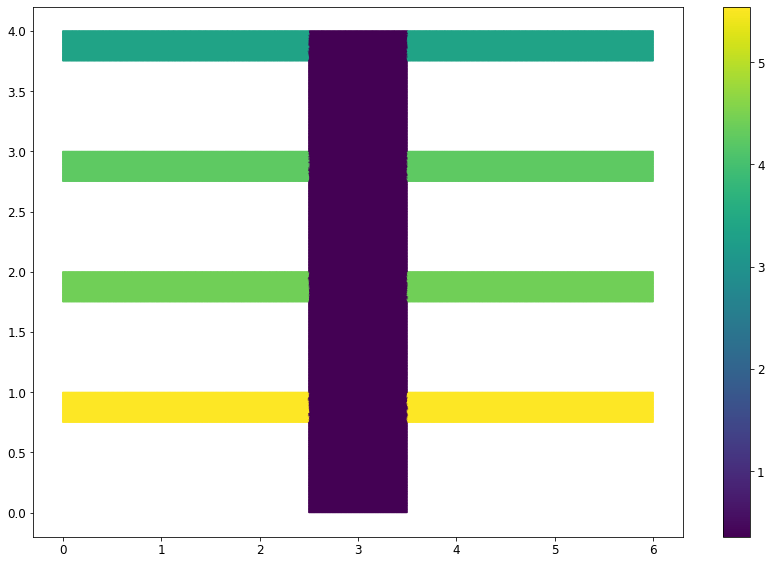

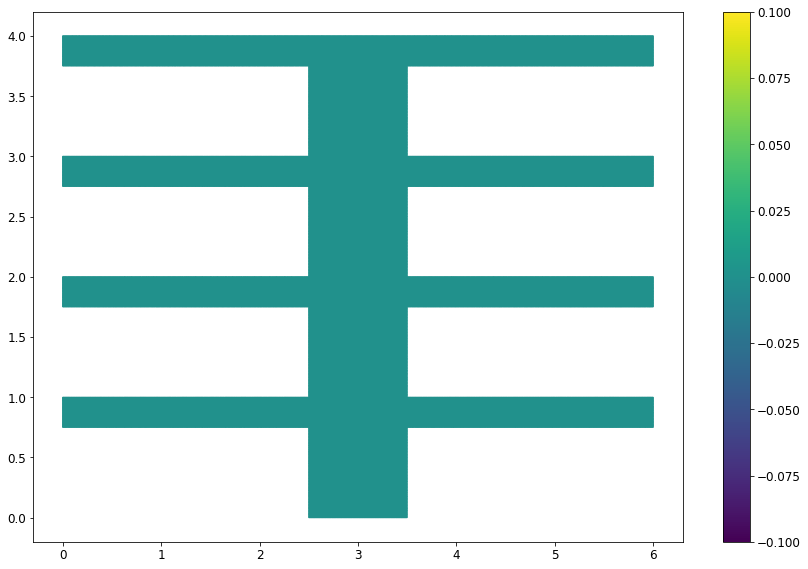

In [6]:
from pymor.discretizers.builtin.cg import InterpolationOperator

vis_mu = mu
diff = InterpolationOperator(data['grid'], problem.diffusion).as_vector(vis_mu)
rhs = InterpolationOperator(data['grid'], problem.rhs).as_vector(vis_mu)
opt_fom.visualize(diff)
opt_fom.visualize(rhs)

We can easily solve the primal and dual equations by calling 

<pymor.discretizers.builtin.gui.jupyter.patch.visualize_patch.<locals>.Plot at 0x7fdf2395dad0>

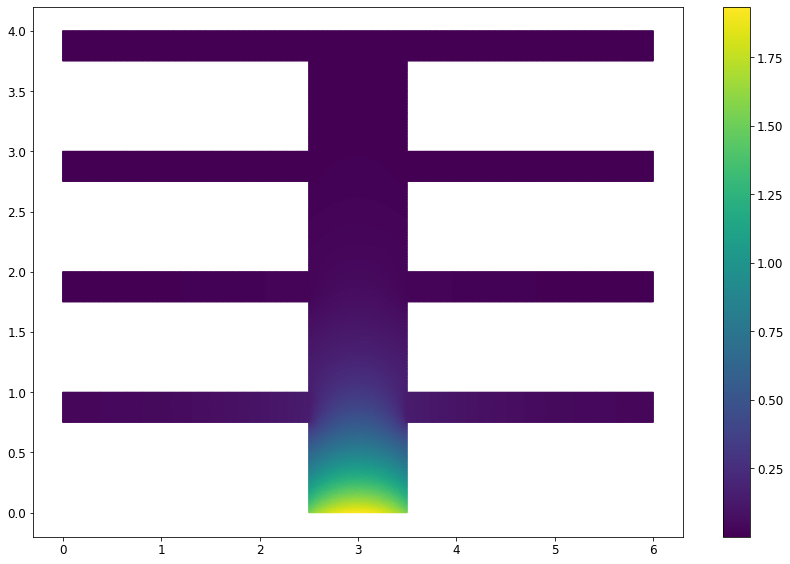

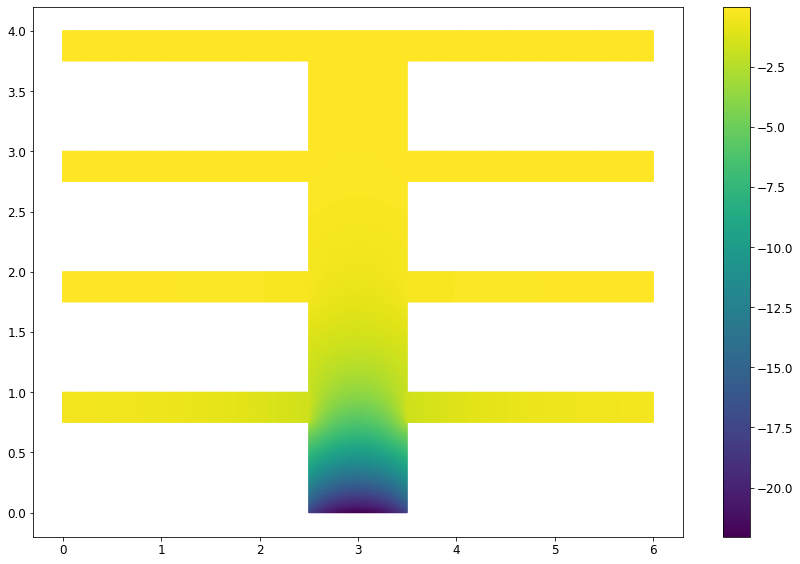

In [7]:
u = opt_fom.solve(mu)
p = opt_fom.solve_dual(mu)

opt_fom.visualize(u)
opt_fom.visualize(p)

# Full Order Optimization

In [8]:
mu_opt = mu_d

mu_opt_as_array = opt_fom.parse_parameter_inverse(mu_opt)
J_opt = opt_fom.output_functional_hat(mu_opt)
print('Optimal parameter: ', mu_opt_as_array)
print('Optimal J: ', J_opt)

print()
print('Starting parameter: ', opt_fom.parse_parameter_inverse(mu))
J_start = opt_fom.output_functional_hat(mu)
print('Starting J: ', J_start)

Optimal parameter:  [0.01       0.1        8.37317446 6.57227607 0.46651735 1.88354107]
Optimal J:  1.0

Starting parameter:  [0.44163495 0.3566697  5.54165853 4.40969169 4.26164124 3.37031473]
Starting J:  1034.354197495633


## FOM BFGS

In [9]:
from pdeopt.TR import solve_optimization_subproblem_BFGS
from pdeopt.tools import compute_errors, compute_actual_errors

TR_parameters = {'radius': 1.e18, 'sub_tolerance': FOC_tolerance, 
                 'max_iterations_subproblem': max_it_sub,
                 'starting_parameter': mu, 
                 'epsilon_i': epsilon_i,
                 'max_iterations_armijo': max_it_arm, 'initial_step_armijo': init_step_armijo,
                 'armijo_alpha': armijo_alpha,
                 'full_order_model': True }


muoptfom,_,_,_, times_2, mus_2, Js_2, FOC_2 = solve_optimization_subproblem_BFGS(opt_fom,opt_fom.parameter_space,mu,TR_parameters, timing=True)
times_full_2, J_error_2, mu_error_2 = compute_errors(opt_fom, J_start, J_opt, mu, mu_opt_as_array, 
                                               mus_2, Js_2, times_2, 0)

Starting parameter {biot: 0.4416349531205837, k0: 0.35666969509612423, k1: 5.541658530999221, k2: 4.409691686920941, k3: 4.261641240666141, k4: 3.370314727938354}
Step [0.01       0.1        5.5389978  4.45851026 0.1        2.95123596], functional 1.5800938663722661 , FOC condition 5.702140734532371
Step [0.0101957  0.10004077 5.5389981  4.45851086 0.10001295 2.95123167], functional 1.578786425380784 , FOC condition 1.7066752795917584
Step [0.01       0.10413758 5.53906075 4.45773129 0.16913797 2.95797956], functional 1.5226440898784404 , FOC condition 1.3628468021342626
Step [0.01       0.1        5.56205202 4.49610843 0.60156913 2.69849286], functional 1.2421328268500815 , FOC condition 2.6993689340412392
Step [0.01008802 0.10001869 5.56205533 4.49611451 0.601571   2.69845125], functional 1.2418471485854923 , FOC condition 0.5551928497569096
Step [0.01019156 0.1        5.56286105 4.49759185 0.60199425 2.68833913], functional 1.2411349283940893 , FOC condition 0.5543521545240256
Step 

Step [0.01008807 0.1000187  5.56535567 4.50177377 0.59829638 2.66147707], functional 1.2311357160816527 , FOC condition 0.5479683930770888
Step [0.01015481 0.1        5.56571159 4.50242454 0.59848558 2.65705667], functional 1.2309402540790018 , FOC condition 0.5476114661179446
Step [0.01       0.1        5.5655571  4.50212461 0.59818966 2.6591826 ], functional 1.2308209588125152 , FOC condition 2.6989049968755774
Step [0.01008807 0.10001869 5.56556011 4.50213011 0.59819139 2.65914521], functional 1.2305363393996487 , FOC condition 0.5476092504801169
Step [0.01015924 0.1        5.56592024 4.50278864 0.59838461 2.65467349], functional 1.230410389798692 , FOC condition 0.5472493357194469
Step [0.01       0.1        5.56573548 4.5024327  0.59806513 2.6571838 ], functional 1.2302873044165068 , FOC condition 2.698815947768099
Step [0.01008807 0.10001869 5.56573854 4.50243829 0.5980669  2.65714579], functional 1.2300025953453968 , FOC condition 0.547270392554907
Step [0.01016372 0.1        5.

Step [0.010088   0.10001868 5.56903022 4.50817526 0.59667112 2.61991504], functional 1.2208339505112207 , FOC condition 0.5418795485579898
Step [0.01014927 0.1        5.56932897 4.50871838 0.59681427 2.61626427], functional 1.2207387831449523 , FOC condition 0.5415883642951165
Step [0.01       0.1        5.56918081 4.50843118 0.59654621 2.61830832], functional 1.2206845367517758 , FOC condition 2.6958525087320195
Step [0.010088   0.10001868 5.56918336 4.50843582 0.59654755 2.61827712], functional 1.2204019214715203 , FOC condition 0.5415888832110279
Step [0.0101523  0.1        5.5694858  4.50898567 0.59669375 2.61458184], functional 1.2203490216519128 , FOC condition 0.541294943548683
Step [0.01       0.1        5.56931802 4.50866234 0.5964115  2.61687214], functional 1.2202904281800073 , FOC condition 2.695845609093959
Step [0.010088   0.10001868 5.56932061 4.50866704 0.59641287 2.61684046], functional 1.220007726093698 , FOC condition 0.5413100332774029
Step [0.01015538 0.1        5.

Step [0.0101176  0.10002482 5.63551928 4.59675098 0.30133906 2.25774627], functional 1.1812231157327915 , FOC condition 0.7677611164032522
Step [0.01019511 0.1        5.63589464 4.59745096 0.30207387 2.25303165], functional 1.181137096978972 , FOC condition 0.7625977600977688
Step [0.01       0.1        5.63589221 4.59740758 0.30172992 2.25361618], functional 1.1809329488367268 , FOC condition 3.4839114523196755
Step [0.01011751 0.1000248  5.63589375 4.59741047 0.3017332  2.25359649], functional 1.1804439941092681 , FOC condition 0.7658137169201849
Step [0.01016068 0.1        5.63608285 4.5977637  0.30211174 2.25121506], functional 1.1803035240820918 , FOC condition 0.763133919904019
Step [0.01002712 0.1        5.63610606 4.59778085 0.30193059 2.25129712], functional 1.180166385262993 , FOC condition 2.5567955589836946
Step [0.0100646  0.1002721  5.63614427 4.59785761 0.30205435 2.25073917], functional 1.1798285792026917 , FOC condition 0.7642403358214003
Step [0.01017443 0.1        5.

Step [0.01008856 0.1000662  5.69214016 4.68719849 0.29231809 1.76926822], functional 1.1640130940411098 , FOC condition 0.8027481869275483
Step [0.0101723  0.1        5.6919573  4.68698732 0.29353121 1.76994804], functional 1.163760177366953 , FOC condition 0.7954939268160742
Step [0.01007842 0.1        5.69209868 4.68720375 0.29346487 1.76888464], functional 1.1630860959341618 , FOC condition 1.0414709406652012
Step [0.01008626 0.10007204 5.69208345 4.68718465 0.29354196 1.76895704], functional 1.1630453715002602 , FOC condition 0.7971718605423446
Step [0.01020031 0.1        5.69181076 4.68689187 0.29574431 1.76976306], functional 1.1625621807264537 , FOC condition 0.7847198681470733
Step [0.01       0.1        5.69328952 4.68917632 0.29541631 1.75844704], functional 1.1623805438036925 , FOC condition 3.4603196161766334
Step [0.01011645 0.10002457 5.69328925 4.689176   0.29541835 1.75844805], functional 1.1619042653241394 , FOC condition 0.7882102311664642
Step [0.01031279 0.1        

Step [0.01001471 0.10038295 5.79094787 4.78917637 0.45036286 2.0715092 ], functional 1.0900244859391108 , FOC condition 0.10631662994741777
Step [0.01031636 0.1        5.91577152 4.95217308 0.49831341 1.69514607], functional 1.0868643429217997 , FOC condition 0.16577884642938473
Step [0.01       0.1        5.95106139 4.97972972 0.46984332 1.90912704], functional 1.071614300797009 , FOC condition 2.4004486297936154
Step [0.01007875 0.10001668 5.95106227 4.97973071 0.46984335 1.9091268 ], functional 1.0713946849262896 , FOC condition 0.05326425852841811
Step [0.01000034 0.1002537  6.06569411 5.10930754 0.47376815 1.87975314], functional 1.0628729227273652 , FOC condition 0.057805958115645054
Step [0.01       0.10217382 7.40116316 6.5917539  0.47853289 1.8169503 ], functional 1.0247980566138324 , FOC condition 0.06465541375503706
Step [0.01       0.1        7.36344261 6.55163792 0.49461851 1.69112422], functional 1.0143302192718124 , FOC condition 1.1615630429291695
Step [0.0100213  0.100

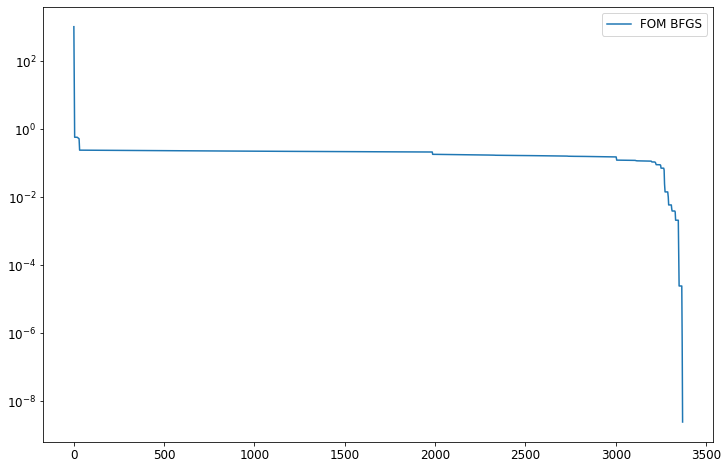

In [10]:
plt.semilogy(times_full_2,J_error_2, label='FOM BFGS')
plt.legend()

# TR approach

In [11]:
from pdeopt.model import build_initial_basis
from pdeopt.reductor import QuadraticPdeoptStationaryCoerciveReductor

from pymor.parameters.functionals import MinThetaParameterFunctional

ce = MinThetaParameterFunctional(opt_fom.primal_model.operator.coefficients, mu_bar)

## BFGS (Lagrange-Basis)

#### NCD-Corrected Functional - Variant 3(a)

In [12]:
import time
tic = time.time()
params = [mu]
opt_fom = opt_fom.with_(use_corrected_functional=True)
opt_fom = opt_fom.with_(use_corrected_gradient=False)
opt_fom = opt_fom.with_(adjoint_approach=True)


RBbasis, dual_RBbasis = build_initial_basis(opt_fom, params, build_sensitivities=False)

pdeopt_reductor = QuadraticPdeoptStationaryCoerciveReductor(opt_fom, 
                                                            RBbasis, dual_RBbasis, 
                                                            opt_product=opt_fom.opt_product,
                                                            coercivity_estimator=ce,
                                                            mu_bar=mu_bar,
                                                            adjoint_estimate=True)

opt_rom = pdeopt_reductor.reduce()

tictoc = time.time() - tic

TR_parameters = {'beta': beta,
                 'safety_tolerance': safety_tol,
                 'radius': radius, 'FOC_tolerance': FOC_tolerance, 
                 'sub_tolerance': sub_tolerance,
                 'max_iterations': max_it, 'max_iterations_subproblem': max_it_sub, 
                 'max_iterations_armijo': max_it_arm,
                 'initial_step_armijo': init_step_armijo, 
                 'armijo_alpha': armijo_alpha, 
                 'epsilon_i': epsilon_i, 
                 'starting_parameter': mu, 
                 'opt_method': 'BFGSMethod'}

extension_params = {"Enlarge_radius": True, 'timings': True}

from pdeopt.TR import TR_algorithm

mus_23, times_23, Js_23, FOC_23 = TR_algorithm(opt_rom, pdeopt_reductor, TR_parameters, extension_params)

times_full_23_actual, J_error_23_actual, mu_error_23_actual, FOC_23_actual = compute_errors(
    opt_fom, J_start, J_opt, mu, mu_opt_as_array, mus_23[1:], Js_23, times_23, tictoc, FOC_23)

Starting with two bases. Primal and dual have length 1 and 1
starting parameter {biot: 0.4416349531205837, k0: 0.35666969509612423, k1: 5.541658530999221, k2: 4.409691686920941, k3: 4.261641240666141, k4: 3.370314727938354}
Starting value of the cost: 1034.3541974956324
******************************* 

___ starting subproblem
Computing the approximate Cauchy point and then start the BFGS method
Curvature condition: -14.319219102641533
Reset direction to - gradient
Curvature condition: -0.05810101203860466
Reset direction to - gradient
boundary criterium of the TR satisfied, so stopping the sub-problem solver
checked sufficient condition, starting the enrichment
Enrichment completed... length of Bases are 2, 2, [] and []
k: 0 - j 4 - Cost Functional: 189.84711378362502 - mu: {biot: 0.16214197016590703, k0: 0.15774898406094154, k1: 5.541576386289474, k2: 4.409789737813889, k3: 4.225846350131973, k4: 3.3694539747043706}
computing the fom gradient since the model was enriched
First order 

Enrichment completed... length of Bases are 13, 13, [] and []
enlarging the TR radius to 102.4
k: 11 - j 46 - Cost Functional: 1.000000000153463 - mu: {biot: 0.01, k0: 0.1, k1: 8.373166720823143, k2: 6.572274914469646, k3: 0.466517240027176, k4: 1.883541017772596}
computing the fom gradient since the model was enriched
First order critical condition: 2.3322735614656297e-05
******************************* 


Stopping criteria fulfilled: FOM FOC condition 2.3322735614656297e-05 


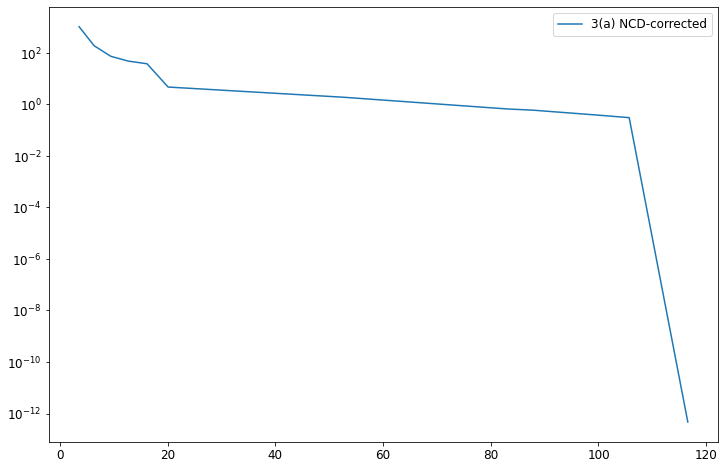

In [13]:
plt.semilogy(times_full_23_actual,J_error_23_actual, label='3(a) NCD-corrected')
plt.legend()

#### Standard approach - Variant 1(a)

In [14]:
import time
tic = time.time()
params = [mu]
opt_fom = opt_fom.with_(use_corrected_functional=False)
opt_fom = opt_fom.with_(use_corrected_gradient=False)
opt_fom = opt_fom.with_(adjoint_approach=False)


RBbasis, dual_RBbasis = build_initial_basis(opt_fom, params, build_sensitivities=False)

pdeopt_reductor = QuadraticPdeoptStationaryCoerciveReductor(opt_fom, 
                                                            RBbasis, dual_RBbasis, 
                                                            opt_product=opt_fom.opt_product,
                                                            coercivity_estimator=ce,
                                                            mu_bar=mu_bar)

opt_rom = pdeopt_reductor.reduce()

tictoc = time.time() - tic

TR_parameters = { 'beta': beta,
                 'safety_tolerance': safety_tol,
                 'radius': radius, 'FOC_tolerance': FOC_tolerance, 
                 'sub_tolerance': sub_tolerance,
                 'max_iterations': max_it, 'max_iterations_subproblem': max_it_sub, 
                 'max_iterations_armijo': max_it_arm,
                 'initial_step_armijo': init_step_armijo, 
                 'armijo_alpha': armijo_alpha, 
                 'epsilon_i': epsilon_i, 
                 'starting_parameter': mu, 
                 'opt_method': 'BFGSMethod'}

extension_params = {"Enlarge_radius": True, 'timings': True}
from pdeopt.TR import TR_algorithm
mus_25, times_25, Js_25, FOC_25 = TR_algorithm(
    opt_rom, pdeopt_reductor, TR_parameters, extension_params)

times_full_25_actual, J_error_25_actual, mu_error_25_actual, FOC_25_actual = compute_errors(
    opt_fom, J_start, J_opt, mu, mu_opt_as_array, mus_25[1:], Js_25, times_25, tictoc, FOC_25)


Starting with two bases. Primal and dual have length 1 and 1
starting parameter {biot: 0.4416349531205837, k0: 0.35666969509612423, k1: 5.541658530999221, k2: 4.409691686920941, k3: 4.261641240666141, k4: 3.370314727938354}
Starting value of the cost: 1034.3541974956324
******************************* 

___ starting subproblem
Computing the approximate Cauchy point and then start the BFGS method
Curvature condition: -14.319219102641846
Reset direction to - gradient
Curvature condition: -0.058101012038606584
Reset direction to - gradient
boundary criterium of the TR satisfied, so stopping the sub-problem solver
checked sufficient condition, starting the enrichment
Enrichment completed... length of Bases are 2, 2, [] and []
k: 0 - j 4 - Cost Functional: 189.84711378362246 - mu: {biot: 0.16214197016590565, k0: 0.15774898406094082, k1: 5.541576386289474, k2: 4.409789737813889, k3: 4.225846350131973, k4: 3.3694539747043706}
computing the fom gradient since the model was enriched
First order

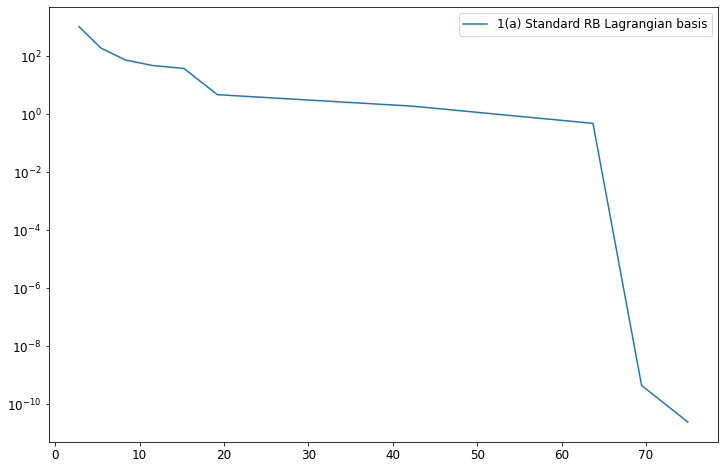

In [15]:
plt.semilogy(times_full_25_actual,J_error_25_actual, label='1(a) Standard RB Lagrangian basis')
plt.legend()

#### Qian et al. 2017 version

In [16]:
#Qian-Grepl
opt_fom = opt_fom.with_(use_corrected_functional=False)
opt_fom = opt_fom.with_(use_corrected_gradient=False)
opt_fom = opt_fom.with_(adjoint_approach=False)
tic = time.time()
params = [mu]


RBbasis, dual_RBbasis = build_initial_basis(opt_fom, params)

pdeopt_reductor = QuadraticPdeoptStationaryCoerciveReductor(opt_fom, 
                                                            RBbasis, dual_RBbasis, 
                                                            opt_product=opt_fom.opt_product, 
                                                            coercivity_estimator=ce, mu_bar=mu_bar,
                                                            prepare_for_gradient_estimate= True)

opt_rom = pdeopt_reductor.reduce()
tictoc = time.time() - tic

TR_parameters = {'Qian-Grepl': True,
                 'beta': beta, 'safety_tolerance': safety_tol,
                 'radius': radius, 'FOC_tolerance': FOC_tolerance, 
                 'sub_tolerance': sub_tolerance,
                 'max_iterations': max_it, 'max_iterations_subproblem': max_it_sub, 
                 'max_iterations_armijo': max_it_arm,
                 'initial_step_armijo': init_step_armijo, 
                 'armijo_alpha': armijo_alpha, 
                 'epsilon_i': epsilon_i,  
                 'starting_parameter': mu, 
                 'opt_method': 'BFGSMethod'}

extension_params = {"Enlarge_radius": False, 'timings': True}

mus_26, times_26,Js_26, FOC_26, opt_rom = TR_algorithm(
    opt_rom, pdeopt_reductor, TR_parameters, extension_params, return_opt_rom=True)

times_full_26_actual, J_error_26_actual, FOC_26_actual, mu_error_26_actual = compute_actual_errors(
    opt_fom, J_start, J_opt, mus_26, times_26, tictoc, mu, mu_opt_as_array)

Starting with two bases. Primal and dual have length 1 and 1
GRAD J ESTIMATOR: non corrected estimator
QIAN et al. 2017 Method
starting parameter {biot: 0.4416349531205837, k0: 0.35666969509612423, k1: 5.541658530999221, k2: 4.409691686920941, k3: 4.261641240666141, k4: 3.370314727938354}
Starting value of the cost: 1034.3541974956324
******************************* 

___ starting subproblem
Computing the approximate Cauchy point and then start the BFGS method
Curvature condition: -14.319219102641846
Reset direction to - gradient
Curvature condition: -0.058101012038606584
Reset direction to - gradient
boundary criterium of the TR satisfied, so stopping the sub-problem solver
checked sufficient condition, starting the enrichment
Enrichment completed... length of Bases are 2, 2, [] and []
GRAD J ESTIMATOR: non corrected estimator
k: 0 - j 4 - Cost Functional: 189.84711378362246 - mu: {biot: 0.16214197016590565, k0: 0.15774898406094082, k1: 5.541576386289474, k2: 4.409789737813889, k3: 4.

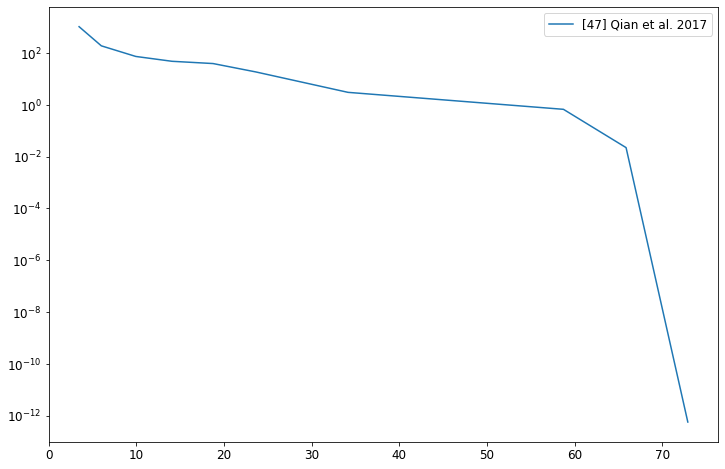

In [17]:
plt.semilogy(times_full_26_actual,J_error_26_actual, label='[47] Qian et al. 2017')
plt.legend()

#### semi NCD-corrected (Variant 2a)

In [18]:
import time
tic = time.time()
params = [mu]
opt_fom = opt_fom.with_(use_corrected_functional=True)
opt_fom = opt_fom.with_(use_corrected_gradient=False)
opt_fom = opt_fom.with_(adjoint_approach=False)


RBbasis, dual_RBbasis = build_initial_basis(opt_fom, params, build_sensitivities=False)

pdeopt_reductor = QuadraticPdeoptStationaryCoerciveReductor(opt_fom, 
                                                            RBbasis, dual_RBbasis, 
                                                            opt_product=opt_fom.opt_product,
                                                            coercivity_estimator=ce,
                                                            mu_bar=mu_bar)

opt_rom = pdeopt_reductor.reduce()

tictoc = time.time() - tic

TR_parameters = {'beta': beta,
                 'safety_tolerance': safety_tol,
                 'radius': radius, 'FOC_tolerance': FOC_tolerance, 
                 'sub_tolerance': sub_tolerance,
                 'max_iterations': max_it, 'max_iterations_subproblem': max_it_sub, 
                 'max_iterations_armijo': max_it_arm,
                 'initial_step_armijo': init_step_armijo, 
                 'armijo_alpha': armijo_alpha,
                 'epsilon_i': epsilon_i, 
                 'starting_parameter': mu}

extension_params = {"Enlarge_radius": True, 'timings': True}

mus_39, times_39, Js_39, FOC_39 = TR_algorithm(
    opt_rom, pdeopt_reductor, TR_parameters, extension_params)

times_full_39_actual, J_error_39_actual, mu_error_39_actual, FOC_39_actual = compute_errors(
    opt_fom, J_start, J_opt, mu, mu_opt_as_array, mus_39[1:], Js_39, times_39, tictoc, FOC_39)

Starting with two bases. Primal and dual have length 1 and 1
starting parameter {biot: 0.4416349531205837, k0: 0.35666969509612423, k1: 5.541658530999221, k2: 4.409691686920941, k3: 4.261641240666141, k4: 3.370314727938354}
Starting value of the cost: 1034.3541974956324
******************************* 

___ starting subproblem
Computing the approximate Cauchy point and then start the BFGS method
Curvature condition: -14.319219102641846
Reset direction to - gradient
Curvature condition: -0.058101012038606584
Reset direction to - gradient
boundary criterium of the TR satisfied, so stopping the sub-problem solver
checked sufficient condition, starting the enrichment
Enrichment completed... length of Bases are 2, 2, [] and []
k: 0 - j 4 - Cost Functional: 189.84711378362266 - mu: {biot: 0.16214197016590565, k0: 0.15774898406094082, k1: 5.541576386289474, k2: 4.409789737813889, k3: 4.225846350131973, k4: 3.3694539747043706}
computing the fom gradient since the model was enriched
First order

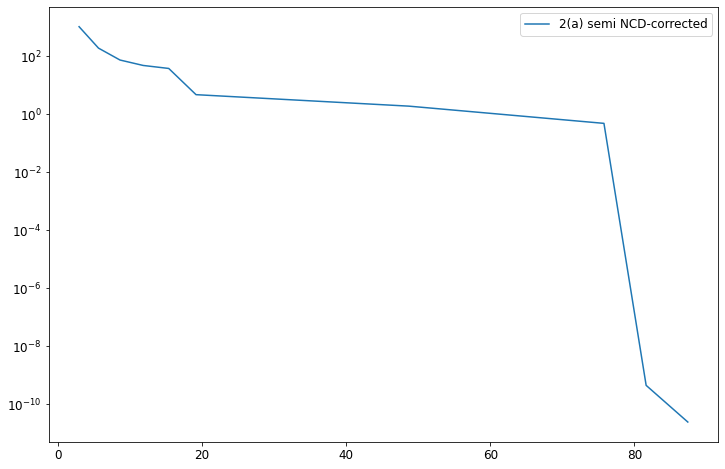

In [19]:
plt.semilogy(times_full_39_actual,J_error_39_actual, label='2(a) semi NCD-corrected')
plt.legend()

## TR BFGS - Single Basis - Variant 1(b)

In [20]:
import time
tic = time.time()
params = [mu]
opt_fom = opt_fom.with_(use_corrected_functional=False)
opt_fom = opt_fom.with_(use_corrected_gradient=False)
opt_fom = opt_fom.with_(adjoint_approach=False)


RBbasis, dual_RBbasis = build_initial_basis(opt_fom, params, build_sensitivities=False)

pdeopt_reductor = QuadraticPdeoptStationaryCoerciveReductor(opt_fom, 
                                                        RBbasis, dual_RBbasis, 
                                                        opt_product=opt_fom.opt_product,
                                                        coercivity_estimator=ce,
                                                        unique_basis=True,
                                                        mu_bar=mu_bar,
                                                        true_lagrange=False)

opt_rom = pdeopt_reductor.reduce()

tictoc = time.time() - tic


TR_parameters = {'beta': beta,
                 'safety_tolerance': safety_tol,
                 'radius': radius, 'FOC_tolerance': FOC_tolerance, 
                 'sub_tolerance': sub_tolerance,
                 'max_iterations': max_it, 'max_iterations_subproblem': max_it_sub, 
                 'max_iterations_armijo': max_it_arm,
                 'initial_step_armijo': init_step_armijo, 
                 'armijo_alpha': armijo_alpha,
                 'epsilon_i': epsilon_i, 
                 'starting_parameter': mu}

extension_params = {"Enlarge_radius": True, 'timings': True}

mus_54, times_54, Js_54, FOC_54 = TR_algorithm(
    opt_rom, pdeopt_reductor, TR_parameters, extension_params)

times_full_54_actual, J_error_54_actual, mu_error_54_actual, FOC_54_actual = compute_errors(
    opt_fom, J_start, J_opt, mu, mu_opt_as_array, mus_54[1:], Js_54, times_54, tictoc, FOC_54)

Starting with only one basis with length 1
starting parameter {biot: 0.4416349531205837, k0: 0.35666969509612423, k1: 5.541658530999221, k2: 4.409691686920941, k3: 4.261641240666141, k4: 3.370314727938354}
Starting value of the cost: 1034.3541974956324
******************************* 

___ starting subproblem
Computing the approximate Cauchy point and then start the BFGS method
Curvature condition: -14.319219102641977
Reset direction to - gradient
Curvature condition: -0.058101012038607756
Reset direction to - gradient
boundary criterium of the TR satisfied, so stopping the sub-problem solver
checked sufficient condition, starting the enrichment
Length of Basis is 2
k: 0 - j 4 - Cost Functional: 189.8471137836221 - mu: {biot: 0.16214197016590565, k0: 0.15774898406093998, k1: 5.541576386289474, k2: 4.409789737813889, k3: 4.225846350131973, k4: 3.3694539747043706}
computing the fom gradient since the model was enriched
First order critical condition: 4.1505601539254
*********************

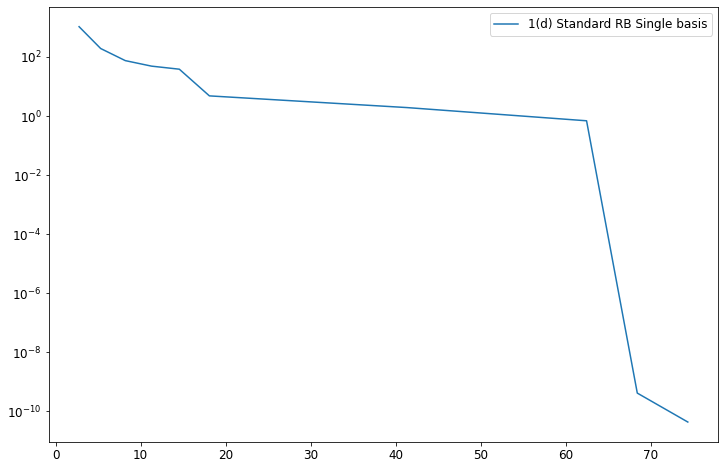

In [21]:
plt.semilogy(times_full_54_actual,J_error_54_actual, label='1(d) Standard RB Single basis')
plt.legend()

# Results

{biot: 0.01, k0: 0.1, k1: 8.37317446377103, k2: 6.572276066240383, k3: 0.46651735398635275, k4: 1.8835410659596712}


<pymor.discretizers.builtin.gui.jupyter.patch.visualize_patch.<locals>.Plot at 0x7fdf2501aed0>

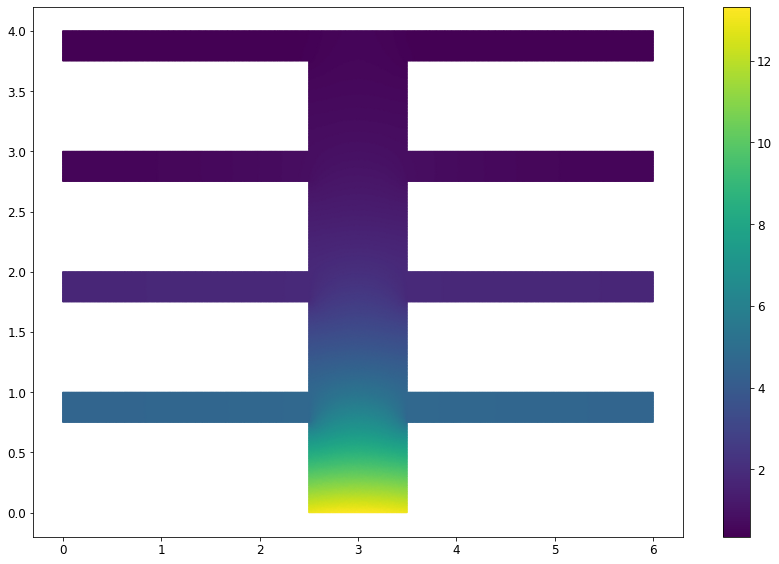

In [22]:
print(mu_opt)
u = opt_fom.solve(mu_opt)
opt_fom.visualize(u)

In [23]:
u = opt_fom.solve(mu_opt)
from pymor.discretizers.builtin.cg import (L2ProductP1, L2ProductQ1, InterpolationOperator)
from pymor.discretizers.builtin.grids.referenceelements import square
from pymor.discretizers.builtin.grids.boundaryinfos import EmptyBoundaryInfo
if data['grid'].reference_element is square:
    L2_OP = L2ProductQ1
else:
    L2_OP = L2ProductP1
if mu_d is None:
    empty_bi = EmptyBoundaryInfo(data['grid'])
    u_d = InterpolationOperator(data['grid'], ConstantFunction(u_d,2)).as_vector()
    diff= u.to_numpy()-u_d.to_numpy()
    diff_= opt_fom.solution_space.from_numpy(diff)
    Restricted_L2_OP = L2_OP(data['grid'], empty_bi, dirichlet_clear_rows=False, coefficient_function=domain_of_interest)
    print("{}".format(Restricted_L2_OP.apply2(diff_,diff_)[0][0]))
    print("{}".format(Restricted_L2_OP.apply2(diff_,diff_)[0][0]/Restricted_L2_OP.apply2(u_d,u_d)))

## Plot results

### J error

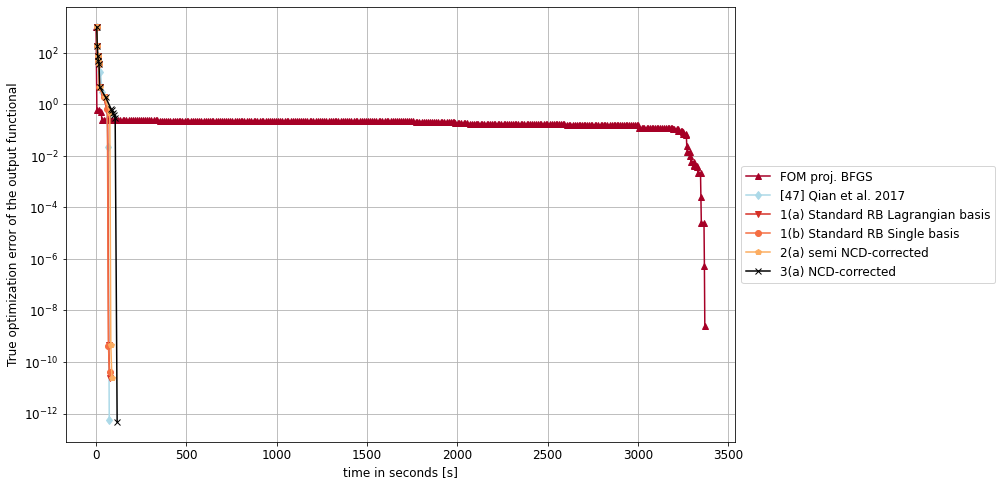

In [24]:
timings_figure = plt.figure()

color0 = (0.65,0,0.15)
color1 = (0.84,0.19,0.15)
color2 = (0.96,0.43,0.26)
color3 = (0.99,0.68,0.38)
color5 = (0.67,0.85,0.91)

#FOM
plt.semilogy(times_full_2,J_error_2,'^-', color=color0, label='FOM proj. BFGS')

# Qian et al. 2017
plt.semilogy(times_full_26_actual,J_error_26_actual,'d-', color=color5, label='[47] Qian et al. 2017')

# Lagrange Basis
plt.semilogy(times_full_25_actual,J_error_25_actual,'v-', color=color1, label='1(a) Standard RB Lagrangian basis')

# Unique Basis
plt.semilogy(times_full_54_actual,J_error_54_actual,'o-', color=color2, label='1(b) Standard RB Single basis')    

# Lagrange Basis
plt.semilogy(times_full_39_actual,J_error_39_actual,'p-', color=color3, label='2(a) semi NCD-corrected')
plt.semilogy(times_full_23_actual,J_error_23_actual,'x-k', label='3(a) NCD-corrected')


plt.xlabel('time in seconds [s]')
plt.ylabel('True optimization error of the output functional')
plt.grid()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

### Plot FOC

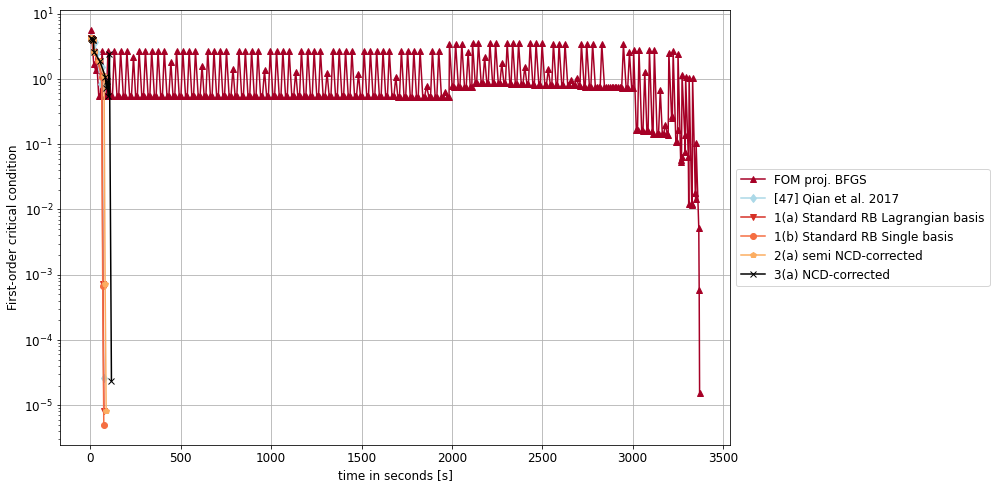

In [25]:
timings_figure = plt.figure()

#FOM
plt.semilogy(times_full_2[1:],FOC_2,'^-', color=color0, label='FOM proj. BFGS')

# Qian et al. 2017
plt.semilogy(times_full_26_actual,FOC_26_actual,'d-', color=color5, label='[47] Qian et al. 2017')

# Lagrange Basis
plt.semilogy(times_full_25_actual,FOC_25_actual,'v-', color=color1, label='1(a) Standard RB Lagrangian basis')

# Unique Basis
plt.semilogy(times_full_54_actual,FOC_54_actual,'o-', color=color2, label='1(b) Standard RB Single basis')    

# Lagrange Basis
plt.semilogy(times_full_39_actual,FOC_39_actual,'p-', color=color3, label='2(a) semi NCD-corrected')
plt.semilogy(times_full_23_actual,FOC_23_actual,'x-k', label='3(a) NCD-corrected')


plt.xlabel('time in seconds [s]')
plt.ylabel('First-order critical condition')
plt.grid()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

### Plot Mu error

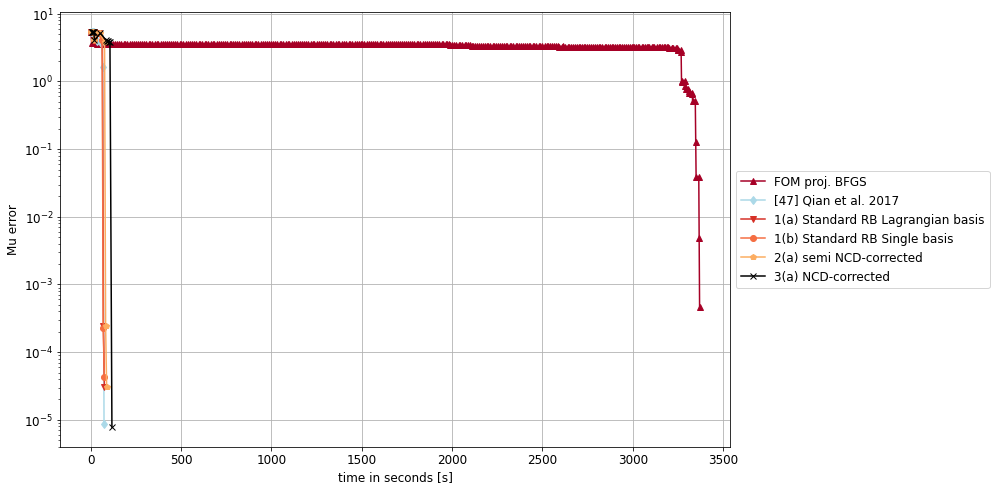

In [26]:
if mu_opt is not None:
    timings_figure = plt.figure()
    
    #FOM
    plt.semilogy(times_full_2,mu_error_2,'^-', color=color0, label='FOM proj. BFGS')

    # Qian et al. 2017
    plt.semilogy(times_full_26_actual,mu_error_26_actual,'d-', color=color5, label='[47] Qian et al. 2017')

    # Lagrange Basis
    plt.semilogy(times_full_25_actual,mu_error_25_actual,'v-', color=color1, label='1(a) Standard RB Lagrangian basis')

    # Unique Basis
    plt.semilogy(times_full_54_actual,mu_error_54_actual,'o-', color=color2, label='1(b) Standard RB Single basis')    

    # Lagrange Basis
    plt.semilogy(times_full_39_actual,mu_error_39_actual,'p-', color=color3, label='2(a) semi NCD-corrected')
    plt.semilogy(times_full_23_actual,mu_error_23_actual,'x-k', label='3(a) NCD-corrected')

    plt.xlabel('time in seconds [s]')
    plt.ylabel('Mu error')
    plt.grid()
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Save the data

In [31]:
#save data
from pdeopt.tools import save_data
directory = 'results/Starter2'
save_data(directory, times_full_2, J_error_2, 2, mu_error=mu_error_2, FOC=FOC_2)
save_data(directory, times_full_23_actual, J_error_23_actual, 23, mu_error=mu_error_23_actual, FOC=FOC_23_actual)
save_data(directory, times_full_25_actual, J_error_25_actual, 25, mu_error=mu_error_25_actual, FOC=FOC_25_actual)
save_data(directory, times_full_26_actual, J_error_26_actual, 26, mu_error=mu_error_26_actual, FOC=FOC_26_actual)
save_data(directory, times_full_39_actual, J_error_39_actual, 39, mu_error=mu_error_39_actual, FOC=FOC_39_actual)
save_data(directory, times_full_54_actual, J_error_54_actual, 54, mu_error=mu_error_54_actual, FOC=FOC_54_actual)